In [2]:
# import necessary modules and display matplotlib plots inline within the ipython notebook webpage

import pandas as pd, numpy as np, statsmodels.api as sm
import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
from scipy.stats import pearsonr, ttest_rel
%matplotlib inline

/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
with open('pg_engine.txt') as f:
    pg_engine = f.readlines()
from sqlalchemy import create_engine
engine = create_engine(pg_engine[0])

In [4]:
%%time
import pandas as pd
df = pd.read_sql_query('select * from "rental_listings"',con=engine)

CPU times: user 1min 10s, sys: 26.7 s, total: 1min 37s
Wall time: 3min 8s


In [5]:
print(df.dtypes)
df.describe()

pid              object
date             object
region           object
neighborhood     object
rent            float64
bedrooms        float64
sqft            float64
rent_sqft       float64
longitude       float64
latitude        float64
county           object
fips_block       object
state            object
bathrooms       float64
dtype: object


rent      bedrooms          sqft     rent_sqft     longitude  \
count  1.552293e+07  1.552293e+07  1.552293e+07  1.552293e+07  1.552293e+07   
mean   4.226986e+04  1.800027e+00  1.058661e+03  5.460696e+01 -9.606330e+01   
std    8.794584e+06  9.483461e-01  9.986804e+03  1.354391e+04  1.675930e+01   
min    1.000000e+00  0.000000e+00  1.000000e+00  1.000001e-06 -1.793005e+02   
25%    8.650000e+02  1.000000e+00  7.350000e+02  9.316062e-01 -1.140619e+02   
50%    1.200000e+03  2.000000e+00  9.380000e+02  1.257692e+00 -9.374646e+01   
75%    1.700000e+03  2.000000e+00  1.165000e+03  1.851852e+00 -8.130969e+01   
max    2.147484e+09  1.270000e+02  8.388607e+06  1.651910e+07  1.000000e+03   

           latitude     bathrooms  
count  1.552293e+07  1.367755e+07  
mean   3.693515e+01  1.168229e+06  
std    5.170104e+00  3.061149e+09  
min   -8.539851e+01  0.000000e+00  
25%    3.345100e+01  1.000000e+00  
50%    3.713274e+01  1.000000e+00  
75%    4.012208e+01  2.000000e+00  
max    1.653830e+02  8.494864e+12

In [6]:
# convert the date column to yyyy-mm-dd date format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df.head()

pid       date       region         neighborhood    rent  bedrooms  \
0  5873872320 2016-11-13     muskegon                        600.0       2.0   
1  5873877617 2016-11-13       merced               Merced   925.0       2.0   
2  5849836436 2016-11-13      bozeman  2990 West Winds Way  1850.0       3.0   
3  5873915596 2016-11-13  myrtlebeach         LANDING ROAD  1200.0       2.0   
4  5862944298 2016-11-13        fayar        2444 Jeremiah  1000.0       3.0   

     sqft  rent_sqft   longitude   latitude      county       fips_block  \
0   700.0   0.857143  -86.235567  43.219625    Muskegon  261210005004029   
1   874.0   1.058352 -120.508000  37.330200      Merced  060470010021060   
2  1566.0   1.181354 -111.079491  45.696211    Gallatin  300310005031204   
3  1150.0   1.043478  -78.877855  33.727425       Horry  450510501021018   
4  1425.0   0.701754  -94.193988  36.096740  Washington  051430105072017   

  state  bathrooms  week  month  year  
0    MI        NaN    45     11  2016  
1    CA        NaN    45     11  2016  
2    MT        NaN    45     11  2016  
3    SC        NaN    45     11  2016  
4    AR        NaN    45     11  2016

In [7]:
df['quarter'] = pd.cut(df['month'],4,labels=False)+1
df.head()

pid       date       region         neighborhood    rent  bedrooms  \
0  5873872320 2016-11-13     muskegon                        600.0       2.0   
1  5873877617 2016-11-13       merced               Merced   925.0       2.0   
2  5849836436 2016-11-13      bozeman  2990 West Winds Way  1850.0       3.0   
3  5873915596 2016-11-13  myrtlebeach         LANDING ROAD  1200.0       2.0   
4  5862944298 2016-11-13        fayar        2444 Jeremiah  1000.0       3.0   

     sqft  rent_sqft   longitude   latitude      county       fips_block  \
0   700.0   0.857143  -86.235567  43.219625    Muskegon  261210005004029   
1   874.0   1.058352 -120.508000  37.330200      Merced  060470010021060   
2  1566.0   1.181354 -111.079491  45.696211    Gallatin  300310005031204   
3  1150.0   1.043478  -78.877855  33.727425       Horry  450510501021018   
4  1425.0   0.701754  -94.193988  36.096740  Washington  051430105072017   

  state  bathrooms  week  month  year  quarter  
0    MI        NaN    45     11  2016        4  
1    CA        NaN    45     11  2016        4  
2    MT        NaN    45     11  2016        4  
3    SC        NaN    45     11  2016        4  
4    AR        NaN    45     11  2016        4

In [8]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [9]:
# define the font styles
family = 'Arial'
title_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

In [9]:
# load the 2014 census data set of MSAs
census = pd.read_csv('data/census_pop_income.csv', encoding='ISO-8859-1')
census['2014_median_income'] = census['2014_median_income'].str.replace(',','').astype(int)
census['2014_pop_est'] = census['2014_pop_est'].str.replace(',','').astype(int)
census = census.drop(labels='notes', axis=1, inplace=False)
census = census.set_index('region')
census.head()

2014_median_income  2014_pop_est  \
region                                         
newyork                  67066      20092883   
losangeles               60514      13262220   
chicago                  61598       9554598   
sfbay                    80600       8607423   
dallas                   59530       6954330   

                                          census_name  
region                                                 
newyork     New York-Newark-Jersey City, NY-NJ-PA MSA  
losangeles     Los Angeles-Long Beach-Anaheim, CA MSA  
chicago        Chicago-Naperville-Elgin, IL-IN-WI MSA  
sfbay          San Jose-San Francisco-Oakland, CA CSA  
dallas            Dallas-Fort Worth-Arlington, TX MSA

In [10]:
# these are the 15 most populous metros by population, defined by census bureau 2014 estimates
most_populous_regions = census['2014_pop_est'].sort_values(ascending=False, inplace=False)
print(most_populous_regions.head(15))

region
newyork         20092883
losangeles      13262220
chicago          9554598
sfbay            8607423
dallas           6954330
houston          6490180
philadelphia     6051170
washingtondc     6033737
miami            5929819
atlanta          5614323
boston           4732161
phoenix          4489109
inlandempire     4441890
detroit          4296611
seattle          3671478
Name: 2014_pop_est, dtype: int64


In [11]:
df['region'].value_counts()

NaN             4546494
washingtondc     551568
losangeles       454082
seattle          449092
sfbay            427732
denver           332128
dallas           288293
phoenix          247287
lasvegas         246258
houston          241171
atlanta          240726
austin           233312
sandiego         232038
portland         231871
miami            223796
philadelphia     195752
chicago          178704
orangecounty     176240
tampa            141619
tucson           135295
orlando          133952
raleigh          128007
baltimore        124028
inlandempire     121970
jacksonville     118095
charlotte        117914
newyork          113682
columbus         113224
sacramento       109845
minneapolis      107522
                 ...   
lasalle             534
outerbanks          526
bemidji             519
potsdam             488
fortdodge           447
montana             428
meadville           413
klamath             408
mendocino           396
butte               391
masoncity       

In [12]:
dfnew = df.merge(census, left_on='region', right_index=True)
dfnew.head()

pid       date      region                         neighborhood  \
59    5873902666 2016-11-13  cincinnati                           Cincinnati   
1702  5839862773 2016-11-13  cincinnati  Cincinnati, Sycamore, Mason, Symmes   
3264  5839904702 2016-11-13  cincinnati  Cincinnati, Sycamore, Mason, Symmes   
4376  5839895285 2016-11-13  cincinnati  Cincinnati, Sycamore, Mason, Symmes   
5020  5874127885 2016-11-13  cincinnati                           Oakley, UT   

        rent  bedrooms    sqft  rent_sqft   longitude   latitude  \
59     875.0       1.0   750.0   1.166667  -84.555389  39.108654   
1702  1250.0       2.0  1151.0   1.086012  -84.330700  39.269200   
3264   935.0       1.0   690.0   1.355072  -84.330700  39.269200   
4376   935.0       1.0   690.0   1.355072  -84.330700  39.269200   
5020   700.0       3.0  2085.0   0.335731 -111.245600  40.724300   

                ...                  fips_block state bathrooms  week  month  \
59              ...             390610096001000    OH       NaN    45     11   
1702            ...             390610243014010    OH       NaN    45     11   
3264            ...             390610243014010    OH       NaN    45     11   
4376            ...             390610243014010    OH       NaN    45     11   
5020            ...             490439642021006    UT       NaN    45     11   

      year  quarter  2014_median_income  2014_pop_est  \
59    2016        4               55729       2149449   
1702  2016        4               55729       2149449   
3264  2016        4               55729       2149449   
4376  2016        4               55729       2149449   
5020  2016        4               55729       2149449   

                   census_name  
59    Cincinnati, OH-KY-IN MSA  
1702  Cincinnati, OH-KY-IN MSA  
3264  Cincinnati, OH-KY-IN MSA  
4376  Cincinnati, OH-KY-IN MSA  
5020  Cincinnati, OH-KY-IN MSA  

[5 rows x 21 columns]

In [10]:
# function to save images consistently
save_dpi = [96, 300]
def save_fig(fig, title, tight=True):    
    if tight:
        fig.tight_layout()
    for dpi in save_dpi:
        save_folder = 'images/dpi_{}/'.format(dpi)
        fig.savefig(save_folder + title, dpi=dpi)

In [11]:
# create ticks and tick labels for the time series
listings_per_date = df['date'].value_counts()
listings_per_date = listings_per_date.sort_index()
listings_per_date = listings_per_date.reset_index()
xticks = listings_per_date.iloc[range(0, len(listings_per_date), 7)].index
xtick_labels = listings_per_date.loc[xticks, 'index']
xtick_labels = [str(x).split()[0] for x in xtick_labels]

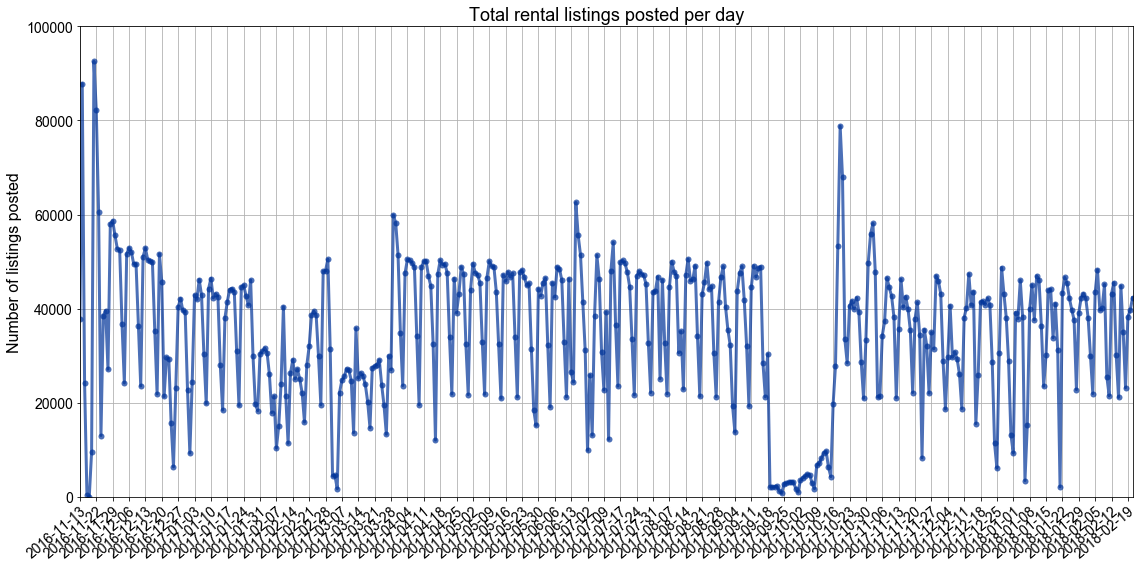

In [12]:
# plot the total number of listings (includes dupes/re-posts) posted on each day in the data set
ax = listings_per_date.plot(kind='line', figsize=[16, 8], ylim=[0,100000], linewidth=3, 
                            marker='o', markeredgewidth=0, alpha=0.7, color='#003399')
ax.grid(True)
ax.set_title('Total rental listings posted per day', fontproperties=title_font)
ax.set_ylabel('Number of listings posted', fontproperties=label_font)
ax.legend_.remove()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

save_fig(plt.gcf(), 'date_count_listings_posted.png')
plt.show()

In [15]:
county_summary_q = df[df['bedrooms']<4].groupby(['state','county','bedrooms','year','quarter'])['rent'].quantile([.01, .05, .5, .95, .99])

In [16]:
county_summary_q = county_summary_q.reset_index()
county_summary_q

state     county  bedrooms  year  quarter  level_5     rent
0         AK  Anchorage       0.0  2016        4     0.01   531.35
1         AK  Anchorage       0.0  2016        4     0.05   656.75
2         AK  Anchorage       0.0  2016        4     0.50   845.00
3         AK  Anchorage       0.0  2016        4     0.95  1581.25
4         AK  Anchorage       0.0  2016        4     0.99  1676.25
5         AK  Anchorage       0.0  2017        1     0.01   632.75
6         AK  Anchorage       0.0  2017        1     0.05   650.00
7         AK  Anchorage       0.0  2017        1     0.50   795.00
8         AK  Anchorage       0.0  2017        1     0.95  1278.00
9         AK  Anchorage       0.0  2017        1     0.99  1541.50
10        AK  Anchorage       0.0  2017        4     0.01   608.50
11        AK  Anchorage       0.0  2017        4     0.05   685.00
12        AK  Anchorage       0.0  2017        4     0.50   805.00
13        AK  Anchorage       0.0  2017        4     0.95  1230.00
14        AK  Anchorage       0.0  2017        4     0.99  1668.25
15        AK  Anchorage       1.0  2016        4     0.01   700.00
16        AK  Anchorage       1.0  2016        4     0.05   726.25
17        AK  Anchorage       1.0  2016        4     0.50  1012.50
18        AK  Anchorage       1.0  2016        4     0.95  1487.50
19        AK  Anchorage       1.0  2016        4     0.99  1775.00
20        AK  Anchorage       1.0  2017        1     0.01   625.00
21        AK  Anchorage       1.0  2017        1     0.05   750.00
22        AK  Anchorage       1.0  2017        1     0.50   929.50
23        AK  Anchorage       1.0  2017        1     0.95  1401.25
24        AK  Anchorage       1.0  2017        1     0.99  1968.25
25        AK  Anchorage       1.0  2017        2     0.01   975.55
26        AK  Anchorage       1.0  2017        2     0.05   977.75
27        AK  Anchorage       1.0  2017        2     0.50  1002.50
28        AK  Anchorage       1.0  2017        2     0.95  1027.25
29        AK  Anchorage       1.0  2017        2     0.99  1029.45
...      ...        ...       ...   ...      ...      ...      ...
225755    WY   Washakie       2.0  2017        2     0.01   601.00
225756    WY   Washakie       2.0  2017        2     0.05   601.00
225757    WY   Washakie       2.0  2017        2     0.50   601.00
225758    WY   Washakie       2.0  2017        2     0.95   601.00
225759    WY   Washakie       2.0  2017        2     0.99   601.00
225760    WY   Washakie       2.0  2017        4     0.01   601.00
225761    WY   Washakie       2.0  2017        4     0.05   601.00
225762    WY   Washakie       2.0  2017        4     0.50   601.00
225763    WY   Washakie       2.0  2017        4     0.95   601.00
225764    WY   Washakie       2.0  2017        4     0.99   601.00
225765    WY   Washakie       2.0  2018        1     0.01   601.00
225766    WY   Washakie       2.0  2018        1     0.05   601.00
225767    WY   Washakie       2.0  2018        1     0.50   601.00
225768    WY   Washakie       2.0  2018        1     0.95   601.00
225769    WY   Washakie       2.0  2018        1     0.99   601.00
225770    WY   Washakie       3.0  2017        4     0.01   675.75
225771    WY   Washakie       3.0  2017        4     0.05   678.75
225772    WY   Washakie       3.0  2017        4     0.50   700.00
225773    WY   Washakie       3.0  2017        4     0.95   949.05
225774    WY   Washakie       3.0  2017        4     0.99   984.21
225775    WY   Washakie       3.0  2018        1     0.01   675.00
225776    WY   Washakie       3.0  2018        1     0.05   675.00
225777    WY   Washakie       3.0  2018        1     0.50   675.00
225778    WY   Washakie       3.0  2018        1     0.95   675.00
225779    WY   Washakie       3.0  2018        1     0.99   675.00
225780    WY     Weston       3.0  2017        4     0.01   799.00
225781    WY     Weston       3.0  2017        4     0.05   799.00
225782    WY     Weston       3.0  2017        4     0

In [13]:
state_summary = df[df['bedrooms']<4].groupby(['state','bedrooms','year','quarter'])['rent', 'rent_sqft'].agg(['median', 'count'])

In [17]:
state_summary = df[df['bedrooms']<4].groupby(['state','bedrooms','year','quarter']).agg({'rent':['median','mean','std'],'rent_sqft':['median','mean', 'std', 'count']})

In [18]:
state_summary

rent                              rent_sqft  \
                             median          mean            std    median   
state bedrooms year quarter                                                  
AK    0.0      2016 4         800.0    900.416667     336.410410  1.689189   
               2017 1         770.0    812.531915     240.744845  1.734234   
                    3        1150.0   1097.500000     380.140690  1.231579   
                    4         795.0    831.543860     270.972622  1.750000   
      1.0      2016 4         950.0    983.900552     229.302035  1.522059   
               2017 1         905.0    960.483607     273.914069  1.472999   
                    2        1002.5   1002.500000      38.890873  1.728448   
                    3         867.5    915.861111     357.218953  1.404762   
                    4         920.0    961.483491     227.512013  1.477778   
               2018 1         900.0    900.000000            NaN  1.125000   
      2.0      2016 4        1195.0   1262.165333     315.698782  1.310383   
               2017 1        1200.0   1216.060976     306.335127  1.270877   
                    2        1190.0   1190.000000     282.842712  1.131818   
                    3        1200.0   1205.264706     312.405956  1.208365   
                    4        1135.0   1220.953488     441.837329  1.250000   
               2018 1        2000.0   2000.000000       0.000000  2.564103   
      3.0      2016 4        1550.0   1584.814815     382.142431  1.168736   
               2017 1        1600.0   1626.030641     371.974945  1.173529   
                    2        1595.0   1598.333333     700.005952  1.139286   
                    3        1500.0   1680.926829     567.819927  1.150000   
                    4        1600.0  42857.808247  908193.329477  1.142983   
AL    0.0      2016 4         699.0   1323.964459   15070.772983  0.838087   
               2017 1         714.0    759.339463     438.987872  0.829220   
                    2         679.0    708.789969     256.019861  0.794521   
                    3         660.0    707.020833     323.806049  0.824561   
                    4         649.0  18772.217207  679851.480874  0.837424   
               2018 1         730.0    778.817771     217.978063  0.857026   
      1.0      2016 4         699.0    923.658396   13419.338196  0.895833   
               2017 1         689.0    692.569958     230.325040  0.884040   
                    2         684.0    688.748513     202.971030  0.907229   
...                             ...           ...            ...       ...   
WV    3.0      2016 4         925.0  63189.179167  825638.958153  0.691057   
               2017 1         950.0  42270.970297  675525.926060  0.695048   
                    2         950.0   1145.162644     687.035964  0.662500   
                    3         925.0  15939.288534  475222.800017  0.694152   
                    4         800.0   1014.603967     608.509572  0.586364   
               2018 1         800.0  27707.619638  501195.255934  0.600000   
WY    0.0      2016 4         699.0    757.620690     314.284609  0.916667   
               2017 1         615.0    697.277778     273.711173  0.826022   
                    2         985.0   1087.716667     534.784198  1.321429   
                    3        1450.5   1221.245098     520.263289  3.152411   
                    4         775.0    945.428571     429.919054  0.901596   
               2018 1        1500.0   1218.315068     463.579937  3.191489   
      1.0      2016 4         785.0    749.908537     241.162899  0.893060   
               2017 1         650.0    707.458967     213.259330  0.904437   
                    2         649.0   2430.909890   35170.125426  1.030928   
                    3         649.0    763.333333     376.742825  0.946839   
                    4         625.0    718.717063     275.780977  0.904437   
               2018 1         629.0    706.163880    

In [19]:
state_summary = state_summary.reset_index()

In [20]:
state_summary

state bedrooms  year quarter    rent                               \
                                   median          mean            std   
0       AK      0.0  2016       4   800.0    900.416667     336.410410   
1       AK      0.0  2017       1   770.0    812.531915     240.744845   
2       AK      0.0  2017       3  1150.0   1097.500000     380.140690   
3       AK      0.0  2017       4   795.0    831.543860     270.972622   
4       AK      1.0  2016       4   950.0    983.900552     229.302035   
5       AK      1.0  2017       1   905.0    960.483607     273.914069   
6       AK      1.0  2017       2  1002.5   1002.500000      38.890873   
7       AK      1.0  2017       3   867.5    915.861111     357.218953   
8       AK      1.0  2017       4   920.0    961.483491     227.512013   
9       AK      1.0  2018       1   900.0    900.000000            NaN   
10      AK      2.0  2016       4  1195.0   1262.165333     315.698782   
11      AK      2.0  2017       1  1200.0   1216.060976     306.335127   
12      AK      2.0  2017       2  1190.0   1190.000000     282.842712   
13      AK      2.0  2017       3  1200.0   1205.264706     312.405956   
14      AK      2.0  2017       4  1135.0   1220.953488     441.837329   
15      AK      2.0  2018       1  2000.0   2000.000000       0.000000   
16      AK      3.0  2016       4  1550.0   1584.814815     382.142431   
17      AK      3.0  2017       1  1600.0   1626.030641     371.974945   
18      AK      3.0  2017       2  1595.0   1598.333333     700.005952   
19      AK      3.0  2017       3  1500.0   1680.926829     567.819927   
20      AK      3.0  2017       4  1600.0  42857.808247  908193.329477   
21      AL      0.0  2016       4   699.0   1323.964459   15070.772983   
22      AL      0.0  2017       1   714.0    759.339463     438.987872   
23      AL      0.0  2017       2   679.0    708.789969     256.019861   
24      AL      0.0  2017       3   660.0    707.020833     323.806049   
25      AL      0.0  2017       4   649.0  18772.217207  679851.480874   
26      AL      0.0  2018       1   730.0    778.817771     217.978063   
27      AL      1.0  2016       4   699.0    923.658396   13419.338196   
28      AL      1.0  2017       1   689.0    692.569958     230.325040   
29      AL      1.0  2017       2   684.0    688.748513     202.971030   
...    ...      ...   ...     ...     ...           ...            ...   
1195    WV      3.0  2016       4   925.0  63189.179167  825638.958153   
1196    WV      3.0  2017       1   950.0  42270.970297  675525.926060   
1197    WV      3.0  2017       2   950.0   1145.162644     687.035964   
1198    WV      3.0  2017       3   925.0  15939.288534  475222.800017   
1199    WV      3.0  2017       4   800.0   1014.603967     608.509572   
1200    WV      3.0  2018       1   800.0  27707.619638  501195.255934   
1201    WY      0.0  2016       4   699.0    757.620690     314.284609   
1202    WY      0.0  2017       1   615.0    697.277778     273.711173   
1203    WY      0.0  2017       2   985.0   1087.716667     534.784198   
1204    WY      0.0  2017       3  1450.5   1221.245098     520.263289   
1205    WY      0.0  2017       4   775.0    945.428571     429.919054   
1206    WY      0.0  2018       1  1500.0   1218.315068     463.579937   
1207    WY      1.0  2016       4   785.0    749.908537     241.162899   
1208    WY      1.0  2017       1   650.0    707.458967     213.259330   
1209    WY      1.0  2017       2   649.0   2430.909890   35170.125426   
1210    WY      1.0  2017       3   649.0    763.333333     376.742825   
1211    WY      1.0  2017       4   625.0    718.717063     275.780977   
1212    WY      1.0  2018       1   629.0    706.163880     241.625931   
1213    WY      2.0  2016       4   675.0    767.016598     516.644595   
1214    WY      2.0  2017       1   679.0    741.544393     210.539258   
1215    WY      2.0  2017       2   699.0    780.951382     232.826022   
1216    W

In [21]:
california = state_summary[state_summary['state']=='CA']
california

state bedrooms  year quarter    rent                              \
                                  median          mean           std   
93     CA      0.0  2016       4  1690.0   6133.585308  2.721394e+05   
94     CA      0.0  2017       1  1720.0   1840.498533  2.064829e+03   
95     CA      0.0  2017       2  1800.0   2944.663385  1.125682e+05   
96     CA      0.0  2017       3  1828.0   6232.892183  5.824692e+05   
97     CA      0.0  2017       4  1719.0   3231.202810  1.497789e+05   
98     CA      0.0  2018       1  1695.0   1803.056153  1.388088e+03   
99     CA      1.0  2016       4  1725.0   3341.948140  1.452795e+05   
100    CA      1.0  2017       1  1709.0   4997.979490  2.123399e+05   
101    CA      1.0  2017       2  1818.0   3593.322008  1.624993e+05   
102    CA      1.0  2017       3  1868.0   4517.989364  1.909436e+05   
103    CA      1.0  2017       4  1735.0   4237.111804  1.704776e+05   
104    CA      1.0  2018       1  1695.0   3287.610349  1.365543e+05   
105    CA      2.0  2016       4  2055.0  21953.963095  6.307343e+06   
106    CA      2.0  2017       1  2025.0   5470.760472  5.481717e+05   
107    CA      2.0  2017       2  2199.0  15170.236223  4.722361e+06   
108    CA      2.0  2017       3  2250.0   7233.995202  2.958895e+05   
109    CA      2.0  2017       4  2004.0   4510.942972  1.854472e+05   
110    CA      2.0  2018       1  1995.0   3654.929184  1.781868e+05   
111    CA      3.0  2016       4  2455.0   5883.208495  4.358761e+05   
112    CA      3.0  2017       1  2515.0   5523.850706  2.591257e+05   
113    CA      3.0  2017       2  2800.0   7191.881391  4.132122e+05   
114    CA      3.0  2017       3  2835.0  13603.155612  1.837111e+06   
115    CA      3.0  2017       4  2500.0   6387.999143  3.473730e+05   
116    CA      3.0  2018       1  2495.0   4944.719029  2.869992e+05   

    rent_sqft                                  
       median       mean          std   count  
93   3.100000  16.219600   892.019847   19371  
94   3.126285   4.153809    34.117486   28622  
95   3.283850   5.883392   262.837942   41546  
96   3.324649   7.692758   334.295210   38315  
97   3.190476   5.908891   251.981427   26478  
98   3.182658   3.887560    33.311110   16740  
99   2.447132   6.286914   320.220491   89780  
100  2.436054  10.084104   559.551154  133498  
101  2.590000   7.482766   478.986460  179896  
102  2.649194   9.287331   456.534983  166691  
103  2.468750   7.741424   350.690644  125648  
104  2.411765   5.159366   188.752099   85764  
105  2.031646  23.623423  6782.213753  115975  
106  2.035714   5.868089   614.037470  167713  
107  2.166667  14.927293  4585.089244  207164  
108  2.210526   8.702021   631.654965  201340  
109  2.041885   4.844341   198.146331  165603  
110  2.012037   3.984011   189.318447  110710  
111  1.739752   4.306610   293.154535   40116  
112  1.825899   3.734785   130.413942   53445  
113  1.995000   4.554134   210.169950   59051  
114  2.003140   4.623218   207.322226   61814  
115  1.857692   4.211601   204.107560   50172  
116  1.825217   3.591209   194.979123   31530

In [22]:
#df['regionNaN'] = df['region']=='NaN'
county_summary = df[df['bedrooms']<4].groupby(['state','county','bedrooms','year','quarter']).agg({'rent':['median','mean','std'],'rent_sqft':['median','mean', 'std', 'count']})

In [23]:
county_summary

rent               \
                                                  median         mean   
state county               bedrooms year quarter                        
AK    Anchorage            0.0      2016 4         845.0   950.000000   
                                    2017 1         795.0   855.875000   
                                         4         805.0   871.409091   
                           1.0      2016 4        1012.5  1018.865079   
                                    2017 1         929.5   981.346939   
                                         2        1002.5  1002.500000   
                                         3         895.0   895.000000   
                                         4         915.0   965.794118   
                           2.0      2016 4        1200.0  1284.747541   
                                    2017 1        1200.0  1257.191136   
                                         2        1190.0  1190.000000   
                                         3         800.0   898.333333   
                                         4        1150.0  1261.390438   
                                    2018 1        2000.0  2000.000000   
                           3.0      2016 4        1650.0  1652.710692   
                                    2017 1        1650.0  1692.988506   
                                         2        1595.0  1598.333333   
                                         3        1500.0  1500.000000   
                                         4        1700.0  1721.724490   
      Fairbanks North Star 0.0      2016 4         700.0   730.555556   
                                    2017 1         700.0   746.111111   
                                         3        1200.0  1203.571429   
                                         4         600.0   633.740741   
                           1.0      2016 4         920.0   891.250000   
                                    2017 1         850.0   918.095238   
                                         3         885.0   950.571429   
                                         4         927.5   938.879310   
                           2.0      2016 4        1275.0  1267.272727   
                                    2017 1        1275.0  1240.357143   
                                         3        1250.0  1252.484848   
...                                                  ...          ...   
WY    Teton                2.0      2017 1        2250.0  2250.000000   
                                         2        2200.0  2062.500000   
                                         3        2500.0  4528.727273   
                                         4        1451.0  1787.666667   
                                    2018 1        1137.5  1536.500000   
                           3.0      2016 4        2850.0  2866.666667   
                                    2017 1        2800.0  3414.285714   
                                         2        2850.0  2737.500000   
                                         3        3035.0  3093.641509   
                                         4        2950.0  2972.129032   
                                    2018 1        2850.0  2851.325581   
      Uinta                0.0      2016 4         330.0   330.000000   
                                    2017 1         330.0   330.000000   
                                         4         350.0   350.000000   
                           2.0      2017 3         550.0   598.333333   
                                         4         750.0   750.000000   
                                    2018 1         495.0   495.000000   
                           3.0      2017 1         800.0   800.000000   
                                         2        1300.0  1175.000000   
                                         3        1050.0  1050.000000   
                                         4         800.0   800.000000   
      Washakie             1.0      2

In [24]:
county_summary = county_summary.reset_index()
ca_summary = county_summary[county_summary['state']=='CA']
ca_summary

state   county bedrooms  year quarter    rent                \
                                            median          mean   
2012    CA  Alameda      0.0  2016       4  1995.0   2082.216809   
2013    CA  Alameda      0.0  2017       1  1933.0   2089.548527   
2014    CA  Alameda      0.0  2017       2  2115.0   2209.832057   
2015    CA  Alameda      0.0  2017       3  2250.0   2311.346913   
2016    CA  Alameda      0.0  2017       4  1963.0   2101.733852   
2017    CA  Alameda      0.0  2018       1  1967.0   2081.680739   
2018    CA  Alameda      1.0  2016       4  2125.0   2216.445507   
2019    CA  Alameda      1.0  2017       1  2100.0   2211.570876   
2020    CA  Alameda      1.0  2017       2  2210.0   2286.190496   
2021    CA  Alameda      1.0  2017       3  2231.5   4047.479724   
2022    CA  Alameda      1.0  2017       4  2166.0   2260.001944   
2023    CA  Alameda      1.0  2018       1  2170.0   2264.240933   
2024    CA  Alameda      2.0  2016       4  2470.0   2614.491573   
2025    CA  Alameda      2.0  2017       1  2570.0  35627.218270   
2026    CA  Alameda      2.0  2017       2  2665.0   2821.048621   
2027    CA  Alameda      2.0  2017       3  2636.0   5382.984264   
2028    CA  Alameda      2.0  2017       4  2566.5   9779.854962   
2029    CA  Alameda      2.0  2018       1  2528.0  11219.253368   
2030    CA  Alameda      3.0  2016       4  3000.0   3107.330675   
2031    CA  Alameda      3.0  2017       1  3067.0   3198.546922   
2032    CA  Alameda      3.0  2017       2  3100.0   3401.613173   
2033    CA  Alameda      3.0  2017       3  3195.0   7805.389563   
2034    CA  Alameda      3.0  2017       4  3100.0   3201.271127   
2035    CA  Alameda      3.0  2018       1  3065.0   3173.818919   
2036    CA   Alpine      0.0  2017       2   925.0    925.000000   
2037    CA   Alpine      0.0  2017       4   875.0    875.000000   
2038    CA   Alpine      1.0  2016       4   525.0    525.000000   
2039    CA   Alpine      1.0  2017       1   660.0    660.000000   
2040    CA   Alpine      1.0  2017       2  1000.0   1083.333333   
2041    CA   Alpine      2.0  2017       2   975.0    967.000000   
...    ...      ...      ...   ...     ...     ...           ...   
3281    CA     Yolo      3.0  2016       4  1950.0   1926.086486   
3282    CA     Yolo      3.0  2017       1  2350.0   2253.711816   
3283    CA     Yolo      3.0  2017       2  2470.0   2387.558824   
3284    CA     Yolo      3.0  2017       3  2150.0   2207.417040   
3285    CA     Yolo      3.0  2017       4  2300.0   2154.936275   
3286    CA     Yolo      3.0  2018       1  2300.0   2314.383117   
3287    CA     Yuba      0.0  2016       4   737.5    737.500000   
3288    CA     Yuba      0.0  2017       1   610.0    635.000000   
3289    CA     Yuba      0.0  2017       2   825.0    887.500000   
3290    CA     Yuba      0.0  2017       3   787.5    787.500000   
3291    CA     Yuba      0.0  2017       4  2100.0   2100.000000   
3292    CA     Yuba      0.0  2018       1  1000.0   1000.000000   
3293    CA     Yuba      1.0  2016       4   613.0    690.388889   
3294    CA     Yuba      1.0  2017       1   762.0    809.057143   
3295    CA     Yuba      1.0  2017       2   795.0    800.666667   
3296    CA     Yuba      1.0  2017       3   700.0    784.037037   
3297    CA     Yuba      1.0  2017       4   795.0    803.260870   
3298    CA     Yuba      1.0  2018       1   795.0    789.176471   
3299    CA     Yuba      2.0  2016       4   845.0    859.059406   
3300    CA     Yuba      2.0  2017       1   875.0    926.693182   
3301    CA     Yuba      2.0  2017       2   875.0    913.055556   
3302    CA     Yuba      2.0  2017       3   897.5    945.500000   
3303    CA     Yuba      2.0  2017       4   915.0   1023.323232   
3304    CA     Yuba      2.0  2018       1   895.0    925.857143   
3305    CA     Yuba      3.0  2016       4  1100.0   1043.382979   
3306    CA     Yuba      3.0  2017       1  1195.0   1181.836

In [28]:
county_summary.to_csv('county_summary.csv')
ca_summary.to_csv('ca_summary.csv')

In [25]:
bay_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']
bayarea_summary = ca_summary[ca_summary['county'].isin(bay_counties)]
bayarea_summary

state        county bedrooms  year quarter    rent                \
                                                 median          mean   
2012    CA       Alameda      0.0  2016       4  1995.0   2082.216809   
2013    CA       Alameda      0.0  2017       1  1933.0   2089.548527   
2014    CA       Alameda      0.0  2017       2  2115.0   2209.832057   
2015    CA       Alameda      0.0  2017       3  2250.0   2311.346913   
2016    CA       Alameda      0.0  2017       4  1963.0   2101.733852   
2017    CA       Alameda      0.0  2018       1  1967.0   2081.680739   
2018    CA       Alameda      1.0  2016       4  2125.0   2216.445507   
2019    CA       Alameda      1.0  2017       1  2100.0   2211.570876   
2020    CA       Alameda      1.0  2017       2  2210.0   2286.190496   
2021    CA       Alameda      1.0  2017       3  2231.5   4047.479724   
2022    CA       Alameda      1.0  2017       4  2166.0   2260.001944   
2023    CA       Alameda      1.0  2018       1  2170.0   2264.240933   
2024    CA       Alameda      2.0  2016       4  2470.0   2614.491573   
2025    CA       Alameda      2.0  2017       1  2570.0  35627.218270   
2026    CA       Alameda      2.0  2017       2  2665.0   2821.048621   
2027    CA       Alameda      2.0  2017       3  2636.0   5382.984264   
2028    CA       Alameda      2.0  2017       4  2566.5   9779.854962   
2029    CA       Alameda      2.0  2018       1  2528.0  11219.253368   
2030    CA       Alameda      3.0  2016       4  3000.0   3107.330675   
2031    CA       Alameda      3.0  2017       1  3067.0   3198.546922   
2032    CA       Alameda      3.0  2017       2  3100.0   3401.613173   
2033    CA       Alameda      3.0  2017       3  3195.0   7805.389563   
2034    CA       Alameda      3.0  2017       4  3100.0   3201.271127   
2035    CA       Alameda      3.0  2018       1  3065.0   3173.818919   
2137    CA  Contra Costa      0.0  2016       4  1774.0   1964.408163   
2138    CA  Contra Costa      0.0  2017       1  1713.0   1742.867841   
2139    CA  Contra Costa      0.0  2017       2  1895.0   1956.683881   
2140    CA  Contra Costa      0.0  2017       3  1885.0   2032.915254   
2141    CA  Contra Costa      0.0  2017       4  1885.5   1969.091398   
2142    CA  Contra Costa      0.0  2018       1  1789.0   1854.883636   
...    ...           ...      ...   ...     ...     ...           ...   
3074    CA        Solano      3.0  2016       4  1800.0   1823.123506   
3075    CA        Solano      3.0  2017       1  2000.0   1996.367589   
3076    CA        Solano      3.0  2017       2  2062.5   2055.222527   
3077    CA        Solano      3.0  2017       3  2000.0   2060.761905   
3078    CA        Solano      3.0  2017       4  2050.0   2174.681648   
3079    CA        Solano      3.0  2018       1  2037.5   2065.472527   
3080    CA        Sonoma      0.0  2016       4  1547.5   1618.437500   
3081    CA        Sonoma      0.0  2017       1  1850.0   1725.931624   
3082    CA        Sonoma      0.0  2017       2  1315.0   1495.917355   
3083    CA        Sonoma      0.0  2017       3  1600.0   1762.664122   
3084    CA        Sonoma      0.0  2017       4  1425.0   2466.267857   
3085    CA        Sonoma      0.0  2018       1  1500.0   1699.777778   
3086    CA        Sonoma      1.0  2016       4  1860.0   1861.830311   
3087    CA        Sonoma      1.0  2017       1  1770.0   1771.149317   
3088    CA        Sonoma      1.0  2017       2  1850.0   2041.007186   
3089    CA        Sonoma      1.0  2017       3  1848.5   1852.246827   
3090    CA        Sonoma      1.0  2017       4  1800.0   1884.222738   
3091    CA        Sonoma      1.0  2018       1  1910.0   1928.432916   
3092    CA        Sonoma      2.0  2016       4  2195.0   2166.141270   
3093    CA        Sonoma      2.0  2017       1  2280.0   2237.739006   
3094    CA        Sonoma      2.0  2017       2  2307.0   2268.652374   
3095    CA        Sonoma      2.0  2017       3  2270.0   2299.

In [26]:
bayarea_summary.to_csv('bayarea_summary.csv')

In [87]:
#store = pd.HDFStore('data/rents.h5')
#store['rents'] = df
df.to_hdf('data/rents.h5','rents',append=False)

/Users/Paul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:1299: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->['pid', 'region', 'neighborhood', 'county', 'fips_block', 'state']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [86]:
store = pd.HDFStore('data/rents.h5')
store.close()

In [12]:
upper_percentile = 0.998
lower_percentile = 0.002

# how many rows would be within the upper and lower percentiles?
upper = int(len(df) * upper_percentile)
lower = int(len(df) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = df['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = df['rent'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = df['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.0121610497168658, 9.8612565445026199]
valid rent range: [15.0, 9888.0]
valid sqft range: [200.0, 4446.0]


In [13]:
# create a boolean vector mask to filter out any rows with rent_sqft outside of the reasonable values
rent_sqft_mask = (df['rent_sqft'] > lower_rent_sqft) & (df['rent_sqft'] < upper_rent_sqft) & (df['bedrooms'] < 6)

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
rent_mask = (df['rent'] > lower_rent) & (df['rent'] < upper_rent)
sqft_mask = (df['sqft'] > lower_sqft) & (df['sqft'] < upper_sqft)

# filter the thorough listings according to these masks
filtered_listings = pd.DataFrame(df[rent_sqft_mask & rent_mask & sqft_mask])
len(filtered_listings)

11664682

In [25]:
filtered_listings.describe()

rent      bedrooms          sqft     rent_sqft     longitude  \
count  1.157198e+07  1.157198e+07  1.157198e+07  1.157198e+07  1.157198e+07   
mean   1.426382e+03  1.794406e+00  1.008182e+03  1.522994e+00 -9.617555e+01   
std    8.336969e+02  9.305693e-01  4.235608e+02  8.640333e-01  1.685698e+01   
min    1.600000e+01  0.000000e+00  2.010000e+02  1.264299e-02 -1.793005e+02   
25%    8.750000e+02  1.000000e+00  7.370000e+02  9.352941e-01 -1.150693e+02   
50%    1.213000e+03  2.000000e+00  9.380000e+02  1.268358e+00 -9.424587e+01   
75%    1.725000e+03  2.000000e+00  1.165000e+03  1.873640e+00 -8.128231e+01   
max    9.899000e+03  5.000000e+00  4.435000e+03  9.889831e+00  1.000000e+03   

           latitude     bathrooms          week         month          year  \
count  1.157198e+07  9.822758e+06  1.157198e+07  1.157198e+07  1.157198e+07   
mean   3.693494e+01  1.626682e+06  2.609823e+01  6.423591e+00  2.016839e+03   
std    5.200653e+00  3.612202e+09  1.501859e+01  3.442091e+00  3.679513e-01   
min   -8.539851e+01  0.000000e+00  1.000000e+00  1.000000e+00  2.016000e+03   
25%    3.344038e+01  1.000000e+00  1.400000e+01  4.000000e+00  2.017000e+03   
50%    3.720985e+01  1.000000e+00  2.600000e+01  6.000000e+00  2.017000e+03   
75%    4.011164e+01  2.000000e+00  3.700000e+01  9.000000e+00  2.017000e+03   
max    1.653830e+02  8.494864e+12  5.200000e+01  1.200000e+01  2.017000e+03   

            quarter  
count  1.157198e+07  
mean   2.495162e+00  
std    1.085750e+00  
min    1.000000e+00  
25%    2.000000e+00  
50%    2.000000e+00  
75%    3.000000e+00  
max    4.000000e+00

In [16]:
filtered_listings['rent_sqft_cat1'] = pd.qcut(filtered_listings['rent_sqft'], 10)
filtered_listings['rent_sqft_cat2'] = pd.cut(filtered_listings['rent_sqft'], 10)


In [15]:
filtered_listings.rent_sqft_cat1.value_counts()

(1.269, 1.458]     1168313
(0.0113, 0.737]    1167206
(0.996, 1.119]     1167137
(2.07, 2.682]      1166467
(2.682, 9.861]     1166451
(0.875, 0.996]     1166390
(1.713, 2.07]      1166259
(1.119, 1.269]     1165822
(0.737, 0.875]     1165809
(1.458, 1.713]     1164828
Name: rent_sqft_cat1, dtype: int64

In [17]:
filtered_listings.rent_sqft_cat2.value_counts()

(0.997, 1.982]      5570960
(0.00246, 0.997]    3504850
(1.982, 2.967]      1762694
(2.967, 3.952]       595314
(3.952, 4.936]       159240
(4.936, 5.921]        48218
(5.921, 6.906]        15193
(6.906, 7.891]         5312
(7.891, 8.876]         2029
(8.876, 9.861]          872
Name: rent_sqft_cat2, dtype: int64

In [26]:
filtered_listings.columns

Index(['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft',
       'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state',
       'bathrooms', 'week', 'month', 'year', 'quarter'],
      dtype='object')

In [17]:
import geojson

def data2geojson(df):
    features = []
    df.apply(lambda X: features.append( 
            geojson.Feature(geometry=geojson.Point((X["longitude"], 
                                                    X["latitude"])), 
                properties=dict(pid=X["pid"], 
                                rent=X["rent"],
                                bedrooms=X["bedrooms"],
                                sqft=X["sqft"],
                                rent_sqft=X["rent_sqft"],
                                month=X["month"],
                                quarter=X["quarter"],
                                year=X["year"],
                                region=X["region"],
                                state=X["state"],
                                fips_block=X["fips_block"]))
                                    )
            , axis=1)
    with open('filtered_listings.geojson', 'w') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True)

In [19]:
%%time
data2geojson(filtered_listings)

CPU times: user 32min 4s, sys: 40.3 s, total: 32min 44s
Wall time: 1h 38min 14s


In [18]:
%%time
filtered_listings.to_csv('filtered_listings.csv')

CPU times: user 3min 24s, sys: 1.33 s, total: 3min 25s
Wall time: 4min 20s


In [27]:
sfbay = filtered_listings[filtered_listings['region']=='sfbay']
sfbay.describe()

rent       bedrooms           sqft      rent_sqft  \
count  422121.000000  422121.000000  422121.000000  422121.000000   
mean     2934.024398       1.742614    1001.047915       3.173049   
std      1114.796669       0.965956     452.487725       1.090553   
min        17.000000       0.000000     202.000000       0.018994   
25%      2205.000000       1.000000     711.000000       2.494048   
50%      2700.000000       2.000000     910.000000       3.000000   
75%      3400.000000       2.000000    1151.000000       3.677073   
max      9888.000000       5.000000    4434.000000       9.889831   

           longitude       latitude      bathrooms           week  \
count  422121.000000  422121.000000  355346.000000  422121.000000   
mean     -122.130030      37.634376       1.483160      25.632714   
std         0.822738       0.347954       0.610834      13.507809   
min      -174.418945      19.528063       0.000000       1.000000   
25%      -122.322500      37.376501       1.000000      15.000000   
50%      -122.074159      37.630446       1.000000      24.000000   
75%      -121.960486      37.800500       2.000000      34.000000   
max         2.496064      64.953325       7.000000      52.000000   

               month           year        quarter  
count  422121.000000  422121.000000  422121.000000  
mean        6.335641    2016.844552       2.429282  
std         3.121549       0.362332       0.978456  
min         1.000000    2016.000000       1.000000  
25%         4.000000    2017.000000       2.000000  
50%         6.000000    2017.000000       2.000000  
75%         8.000000    2017.000000       3.000000  
max        12.000000    2017.000000       4.000000

In [33]:
sfbay.columns

Index(['pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft',
       'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state',
       'bathrooms', 'week', 'month', 'year'],
      dtype='object')

In [28]:
sfbay.to_csv('data/sfbay_listings_091_02_2017.csv')

In [35]:
sfbay_sept = sfbay[sfbay['month']==9]

In [36]:
sfbay_sept.describe()

rent      bedrooms          sqft     rent_sqft     longitude  \
count  30301.000000  30301.000000  30301.000000  30301.000000  30301.000000   
mean    2973.456718      1.772516   1015.012145      3.193192   -122.113992   
std     1095.293928      0.982335    475.511780      1.085101      1.170640   
min       21.000000      0.000000    203.000000      0.033600   -157.698500   
25%     2295.000000      1.000000    715.000000      2.511990   -122.305942   
50%     2750.000000      2.000000    920.000000      3.013959   -122.070774   
75%     3400.000000      2.000000   1155.000000      3.687500   -121.960317   
max     9950.000000      8.000000   4347.000000      9.775510      2.496064   

           latitude     bathrooms          week    month     year  
count  30301.000000  29681.000000  30301.000000  30301.0  30301.0  
mean      37.632033      1.497827     36.344543      9.0   2017.0  
std        0.358703      0.622051      0.753101      0.0      0.0  
min       21.298700      0.000000     35.000000      9.0   2017.0  
25%       37.375874      1.000000     36.000000      9.0   2017.0  
50%       37.618999      1.000000     36.000000      9.0   2017.0  
75%       37.800443      2.000000     37.000000      9.0   2017.0  
max       48.975011      5.500000     38.000000      9.0   2017.0

In [37]:
sfbay_sept.to_csv('data/sfbay_sept.csv')

In [22]:
sfbay['rent_sqft'].quantile(.01)

1.0

In [29]:
sfbay['sqft'].quantile(.01)

356.0

In [24]:
# create a boolean vector mask to filter out any rows with rent_sqft and sqft in Bay Area under 1 percentile
sfbay_rent_sqft_mask = (sfbay['rent_sqft'] > sfbay['rent_sqft'].quantile(.01) )

# create boolean vector masks to filter out any rows with rent or sqft outside of the reasonable values
sfbay_sqft_mask = (sfbay['sqft'] > sfbay['sqft'].quantile(.01) )

# filter the thorough listings according to these masks
sfbay_filtered = pd.DataFrame(sfbay[sfbay_rent_sqft_mask & sfbay_sqft_mask])
len(sfbay_filtered)

414026

In [25]:
sfbay_filtered.describe()

rent       bedrooms           sqft      rent_sqft  \
count  414026.000000  414026.000000  414026.000000  414026.000000   
mean     2967.380730       1.749873    1000.990389       3.170984   
std      1113.066294       0.961082     439.302661       1.024050   
min       600.000000       0.000000     356.000000       1.000743   
25%      2250.000000       1.000000     714.000000       2.500000   
50%      2716.000000       2.000000     910.000000       3.000000   
75%      3420.000000       2.000000    1150.000000       3.666667   
max      9990.000000       8.000000    4434.000000       9.960159   

           longitude       latitude     bathrooms           week  \
count  414026.000000  414026.000000  349316.00000  414026.000000   
mean     -122.134264      37.633624       1.48380      25.625444   
std         0.731489       0.336244       0.60949      13.503724   
min      -174.418945      19.528063       0.00000       1.000000   
25%      -122.319836      37.376400       1.00000      15.000000   
50%      -122.071860      37.608700       1.00000      24.000000   
75%      -121.960486      37.800075       2.00000      34.000000   
max         2.496064      48.975011       7.00000      52.000000   

               month           year  
count  414026.000000  414026.000000  
mean        6.334093    2016.844742  
std         3.120788       0.362151  
min         1.000000    2016.000000  
25%         4.000000    2017.000000  
50%         6.000000    2017.000000  
75%         8.000000    2017.000000  
max        12.000000    2017.000000

In [32]:
geocoded = pd.read_csv('data/craigslist_data_wblockid.csv', dtype={'GEOID10': object}).rename(columns={'GEOID10':'fips_block'})

In [33]:
# convert the date column to yyyy-mm-dd date format
geocoded['date'] = pd.to_datetime(geocoded['date'], format='%Y-%m-%d')
geocoded['week'] = geocoded['date'].dt.week
geocoded['month'] = geocoded['date'].dt.month
geocoded['year'] = geocoded['date'].dt.year
geocoded.head()

index         pid       date        region     neighborhood    rent  \
0      0  4454264047 2014-05-11  santabarbara              NaN  3500.0   
1      1  4437398427 2014-05-11  santabarbara  6533 Trigo Road   850.0   
2      2  4437286111 2014-05-11  santabarbara         downtown  2795.0   
3      3  4465598705 2014-05-11  santabarbara    santa barbara  5000.0   
4      4  4465561098 2014-05-11  santabarbara           Lompoc  1330.0   

   bedrooms    sqft  rent_sqft  rent_sqft_cat   longitude   latitude  \
0       3.0  1200.0   2.916667              5 -119.726987  34.399757   
1       2.0   882.0   0.963719              2 -119.855845  34.411019   
2       3.0  1200.0   2.329167              5 -119.712193  34.413942   
3       3.0  2000.0   2.500000              5 -119.692343  34.431691   
4       2.0  1000.0   1.330000              4 -120.469315  34.703429   

                                                geom       fips_block  week  \
0  0101000020E61000007F677BF486EE5DC06DACC43C2B33...  060830013048000    19   
1  0101000020E61000007D5C1B2AC6F65DC06F8445459C34...  060830029242004    19   
2  0101000020E61000002BDCF29194ED5DC06D382C0DFC34...  060830012031000    19   
3  0101000020E610000054A703594FEC5DC0207D93A64137...  060830006002000    19   
4  0101000020E61000006C21C841091E5EC06C0723F6095A...  060830028084014    19   

   month  year  
0      5  2014  
1      5  2014  
2      5  2014  
3      5  2014  
4      5  2014

In [34]:
print(geocoded.columns)
geocoded.describe()

Index(['index', 'pid', 'date', 'region', 'neighborhood', 'rent', 'bedrooms',
       'sqft', 'rent_sqft', 'rent_sqft_cat', 'longitude', 'latitude', 'geom',
       'fips_block', 'week', 'month', 'year'],
      dtype='object')


index           pid          rent      bedrooms          sqft  \
count  1.367142e+06  1.367142e+06  1.367142e+06  1.301693e+06  1.367142e+06   
mean   7.330246e+05  4.502898e+09  1.340748e+03  2.047311e+00  1.074148e+03   
std    4.206196e+05  3.252243e+07  8.156975e+02  9.272406e-01  5.103953e+02   
min    0.000000e+00  4.417508e+09  1.900000e+02  1.000000e+00  2.210000e+02   
25%    3.685862e+05  4.477738e+09  7.990000e+02  1.000000e+00  7.500000e+02   
50%    7.363475e+05  4.496396e+09  1.115000e+03  2.000000e+00  9.620000e+02   
75%    1.096559e+06  4.530615e+09  1.650000e+03  3.000000e+00  1.214000e+03   
max    1.456337e+06  4.574744e+09  1.028500e+04  8.000000e+00  5.192000e+03   

          rent_sqft  rent_sqft_cat     longitude      latitude          week  \
count  1.367142e+06   1.367142e+06  1.367142e+06  1.367142e+06  1.367142e+06   
mean   1.352719e+00   2.980504e+00 -1.012379e+02  3.708709e+01  2.294748e+01   
std    7.836169e-01   1.388046e+00  1.789768e+01  5.336504e+00  2.612611e+00   
min    1.004464e-01   1.000000e+00 -1.644361e+02  1.904303e+01  1.900000e+01   
25%    8.279793e-01   2.000000e+00 -1.179548e+02  3.354999e+01  2.100000e+01   
50%    1.096681e+00   3.000000e+00 -1.047681e+02  3.707657e+01  2.200000e+01   
75%    1.661392e+00   4.000000e+00 -8.338839e+01  4.033090e+01  2.500000e+01   
max    1.260504e+01   5.000000e+00 -6.702982e+01  6.591511e+01  2.900000e+01   

              month       year  
count  1.367142e+06  1367142.0  
mean   5.587902e+00     2014.0  
std    6.795093e-01        0.0  
min    5.000000e+00     2014.0  
25%    5.000000e+00     2014.0  
50%    5.000000e+00     2014.0  
75%    6.000000e+00     2014.0  
max    7.000000e+00     2014.0

In [35]:
geocoded6 = geocoded[geocoded['month']==6]
print(geocoded6['region'].value_counts().head(60))

sfbay           32331
seattle         28460
sandiego        22725
orangecounty    20413
losangeles      19327
sacramento      16313
inlandempire    16112
denver          15397
phoenix         15310
portland        13096
lasvegas        12284
washingtondc    11726
tucson          11131
dallas           9614
chicago          8623
houston          7198
miami            7184
fresno           5820
stlouis          5437
atlanta          5151
orlando          4837
newyork          4723
austin           4641
minneapolis      4521
tampa            4488
albuquerque      4473
boston           4440
cosprings        4250
kansascity       3666
reno             3504
raleigh          3450
spokane          3421
oklahomacity     3289
philadelphia     3246
charlotte        3184
jacksonville     3118
saltlakecity     3081
richmond         2944
ventura          2825
indianapolis     2631
norfolk          2556
columbus         2535
neworleans       2370
baltimore        2335
sanantonio       2320
milwaukee 

In [36]:
sfbay_geocoded = geocoded[geocoded['region']=='sfbay']
sfbay_geocoded.describe()

index           pid          rent      bedrooms          sqft  \
count  7.176700e+04  7.176700e+04  71767.000000  67161.000000  71767.000000   
mean   8.761931e+05  4.515081e+09   2529.436663      1.909218   1026.495311   
std    4.053274e+05  3.043084e+07   1104.966850      0.918099    503.167676   
min    6.064000e+03  4.419377e+09    285.000000      1.000000    221.000000   
25%    5.658775e+05  4.487801e+09   1835.000000      1.000000    722.000000   
50%    9.502680e+05  4.518829e+09   2325.000000      2.000000    903.000000   
75%    1.261562e+06  4.541766e+09   2954.000000      2.000000   1152.000000   
max    1.450750e+06  4.567896e+09  10250.000000      8.000000   5157.000000   

          rent_sqft  rent_sqft_cat     longitude      latitude          week  \
count  71767.000000   71767.000000  71767.000000  71767.000000  71767.000000   
mean       2.654153       4.733903   -122.113709     37.643169     23.836554   
std        0.948447       0.617483      0.415524      0.345550      2.651982   
min        0.140476       1.000000   -157.845039     21.290814     19.000000   
25%        2.054945       5.000000   -122.283936     37.378580     21.000000   
50%        2.578947       5.000000   -122.047200     37.586396     24.000000   
75%        3.111111       5.000000   -121.952200     37.844122     26.000000   
max       10.611888       5.000000    -70.690600     47.577915     28.000000   

              month     year  
count  71767.000000  71767.0  
mean       5.817521   2014.0  
std        0.718477      0.0  
min        5.000000   2014.0  
25%        5.000000   2014.0  
50%        6.000000   2014.0  
75%        6.000000   2014.0  
max        7.000000   2014.0

In [37]:
from pyproj import Proj, transform

## Datashader needs the location in web mercator coordiates

# WGS 84
inProj = Proj(init='epsg:4326')

# Web mercator 
outProj = Proj(init='epsg:3857')

geocoded['X'],geocoded['Y'] = transform(inProj,outProj,geocoded['longitude'].values,geocoded['latitude'].values)
geocoded[['X','Y']].describe()

X             Y
count  1.367142e+06  1.367142e+06
mean  -1.126975e+07  4.478751e+06
std    1.992361e+06  7.627512e+05
min   -1.830494e+07  2.160003e+06
25%   -1.313067e+07  3.968535e+06
50%   -1.166274e+07  4.449786e+06
75%   -9.282754e+06  4.914144e+06
max   -7.461725e+06  9.853650e+06

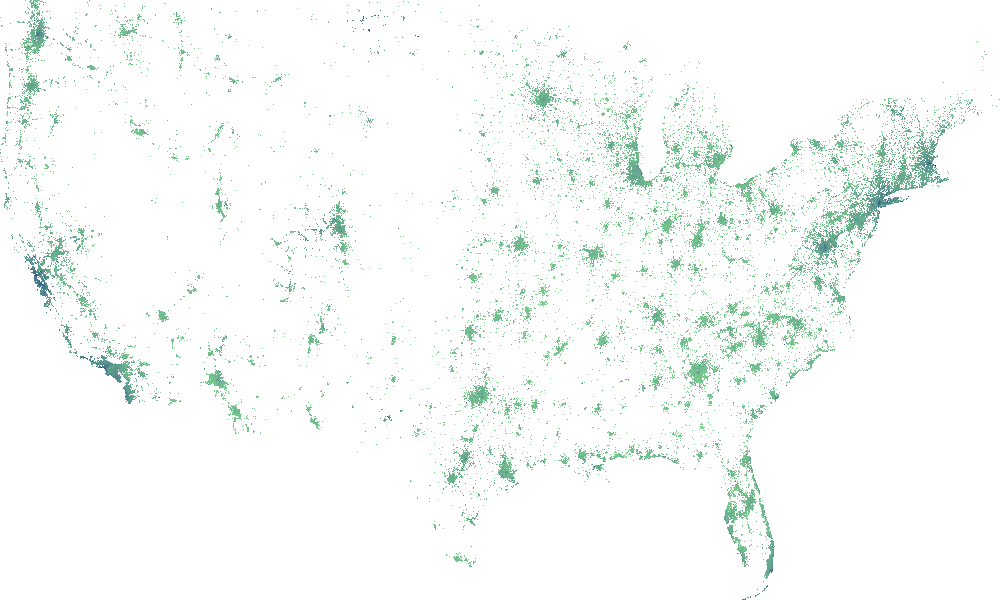

In [38]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

US_XMin = -124.848974
US_XMax = -66.885444

US_YMin = 24.396308
US_YMax = 49.384358

geocoded = geocoded[(geocoded['longitude']>US_XMin) & (geocoded['longitude']<US_XMax)]
geocoded = geocoded[(geocoded['latitude']>US_YMin) & (geocoded['latitude']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(geocoded, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

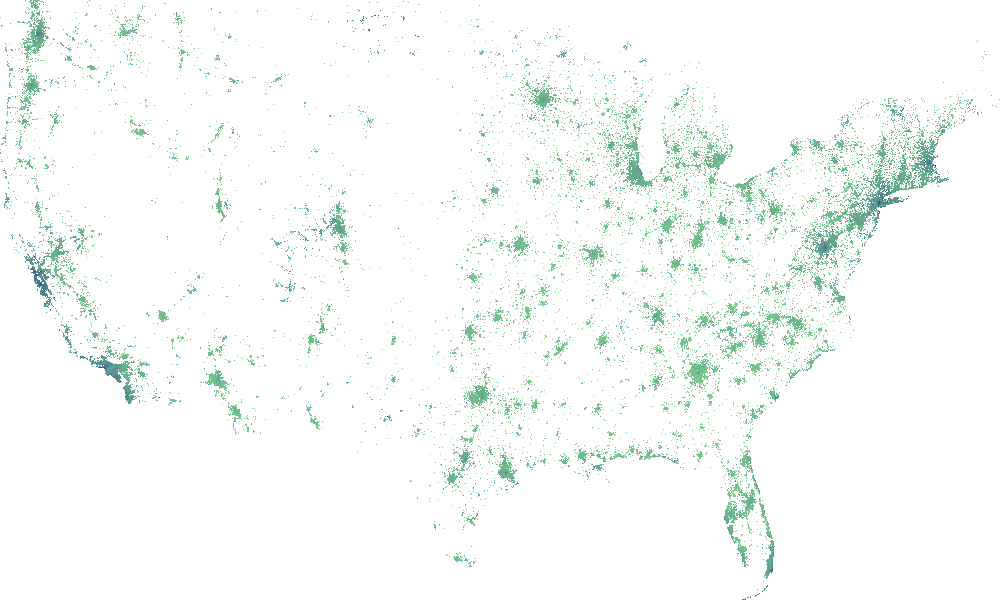

In [39]:
import datashader as ds
import datashader.transfer_functions as tf
import pandas as pd

US_XMin = -1.385944e+07
US_XMax = -7.461725e+06

US_YMin = 2.820464e+06
US_YMax = 6.274965e+06

geocoded = geocoded[(geocoded['X']>US_XMin) & (geocoded['X']<US_XMax)]
geocoded = geocoded[(geocoded['Y']>US_YMin) & (geocoded['Y']<US_YMax)]

cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(geocoded, 'longitude', 'latitude', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

In [40]:
filtered_listings['X'],filtered_listings['Y'] = transform(inProj,outProj,filtered_listings['longitude'].values,filtered_listings['latitude'].values)

US_XMin = -1.385944e+07
US_XMax = -7.461725e+06

US_YMin = 2.820464e+06
US_YMax = 6.274965e+06

filtered_listings = filtered_listings[(filtered_listings['X']>US_XMin) & (filtered_listings['X']<US_XMax)]
filtered_listings = filtered_listings[(filtered_listings['Y']>US_YMin) & (filtered_listings['Y']<US_YMax)]

filtered_listings[['longitude','latitude','X','Y']].describe()

longitude      latitude             X             Y
count  1.156517e+07  1.156517e+07  1.156517e+07  1.156517e+07
mean  -9.614706e+01  3.692956e+01 -1.070304e+07  4.454191e+06
std    1.679751e+01  5.167987e+00  1.869890e+06  7.273862e+05
min   -1.244992e+02  2.454920e+01 -1.385919e+07  2.820474e+06
25%   -1.150669e+02  3.344118e+01 -1.280919e+07  3.954011e+06
50%   -9.421769e+01  3.720591e+01 -1.048827e+07  4.467847e+06
75%   -8.128140e+01  4.010990e+01 -9.048204e+06  4.881926e+06
max   -6.709290e+01  4.900049e+01 -7.468747e+06  6.274945e+06

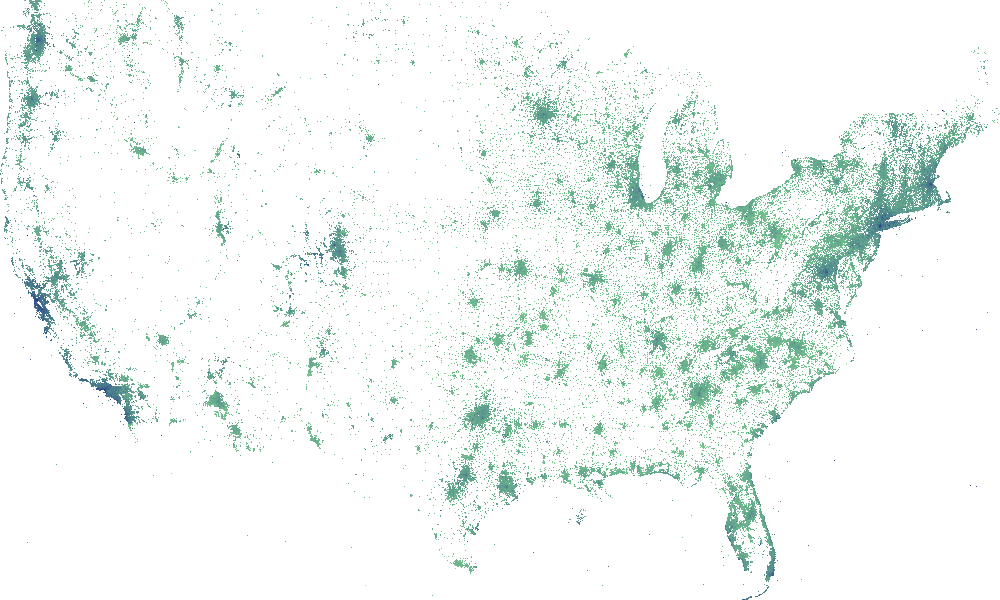

In [41]:
cvs = ds.Canvas(plot_width=1000, plot_height=600)
agg = cvs.points(filtered_listings, 'X', 'Y', ds.mean('rent_sqft'))
img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')
img

In [42]:
import datashader as ds 
import datashader.transfer_functions as tf
from datashader.colors import Greys9, Hot, colormap_select as cm 
def bg(img): return tf.set_background(img,"black")

In [43]:
#USA = ((-124.848974, -66.885444), (24.396308, 49.384358))
USA = ((-1.385944e+07, -7.461725e+06), (2.820464e+06, 6.274965e+06)) 
x_range,y_range = USA
 
plot_width = int(900)
plot_height = int(plot_width*7.0/12)

In [44]:
def create_image(x_range, y_range, w=plot_width, h=plot_height, spread=0):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'meterswest', 'metersnorth', ds.count_cat('race'))
    img = tf.colorize(agg, color_key, how='eq_hist')
    if spread: img = tf.spread(img,px=spread)
    return tf.set_background(img,"black")

In [45]:
from bokeh.tile_providers import STAMEN_TERRAIN
from bokeh.tile_providers import STAMEN_TONER
from bokeh.tile_providers import CARTODBPOSITRON_RETINA

from bokeh.embed import file_html
from bokeh.plotting import figure, output_notebook, output_file, show
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from bokeh.resources import CDN
from bokeh.io import save


from functools import partial

output_notebook()

Loading BokehJS ...

In [46]:
import bokeh.plotting as bp
from bokeh.models.tiles import WMTSTileSource
 
bp.output_notebook()
 
def base_plot(tools='pan,wheel_zoom,reset',webgl=False):
     p = bp.figure(tools=tools,
         plot_width=int(900), plot_height=int(500),
         x_range=x_range, y_range=y_range, outline_line_color=None,
         min_border=0, min_border_left=0, min_border_right=0,
         min_border_top=0, min_border_bottom=0, webgl=webgl)
 
     p.axis.visible = False
     p.xgrid.grid_line_color = None
     p.ygrid.grid_line_color = None
 
     return p
 
p = base_plot()
 
url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png" 
tile_renderer = p.add_tile(WMTSTileSource(url=url)) 
tile_renderer.alpha=1.0

Loading BokehJS ...

/Users/Paul/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: webgl was deprecated in Bokeh 0.12.6 and will be removed, use output_backend instead.
  warn(message)


In [48]:
#US = x_range, y_range = ((df_slice.xWeb.min(),df_slice.xWeb.max()), (4898057.594904038,5565974.539663678))
USA = ((-1.385944e+07, -7.461725e+06), (2.820464e+06, 6.274965e+06)) 
x_range,y_range = USA

plot_width  = int(900)
plot_height = int(plot_width//1.4)


def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height, webgl=True,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(filtered_listings, 'X', 'Y', ds.mean('rent_sqft'))
    img = tf.shade(agg, cmap=['lightgreen', 'darkblue'], how='log')

    #img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot()
p.add_tile(CARTODBPOSITRON_RETINA)

# this export step is not neccesary - it saves a PNG of the file
#export(create_image(*USA),"US_CL")
#html = save(p, "craigslist")


# this is where the magic happens
InteractiveImage(p, create_image)

/Users/Paul/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: webgl was deprecated in Bokeh 0.12.6 and will be removed, use output_backend instead.
  warn(message)


In [49]:
Html_file= open("craigslist.html","w")
Html_file.write(html)
Html_file.close()

NameError: name 'html' is not defined

In [50]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay_geocoded, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                 1.730e+04
Date:                Thu, 02 Nov 2017   Prob (F-statistic):               0.00
Time:                        20:41:19   Log-Likelihood:                -17929.
No. Observations:               67161   AIC:                         3.586e+04
Df Residuals:                   67158   BIC:                         3.589e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.7433      0.037     73.276   

In [ ]:
errors =  res.resid
errors.hist(bins=25)

In [ ]:
pred = res.fittedvalues
pred.hist(bins=25)

In [ ]:
plt.figure(1, figsize=(10,8), )
plt.scatter(res.fittedvalues, res.resid, s=.03, color='green')
plt.show();

In [29]:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
y, X = dmatrices('np.log(rent) ~ np.log(sqft) + bedrooms', data=sfbay_filtered, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(rent)   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 1.275e+05
Date:                Wed, 20 Sep 2017   Prob (F-statistic):               0.00
Time:                        09:04:56   Log-Likelihood:                -37080.
No. Observations:              414026   AIC:                         7.417e+04
Df Residuals:                  414023   BIC:                         7.420e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9886      0.012    326.711   

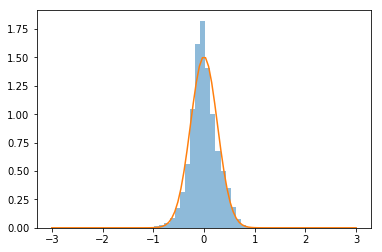

In [30]:
plt.hist(residuals, bins=25, normed=True, alpha=.5)
mu = residuals.mean()
variance = residuals.var()
sigma = residuals.std()
x = np.linspace(-3, 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma));

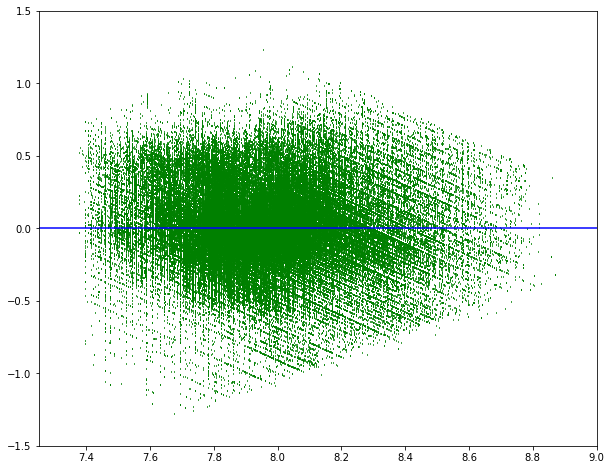

In [31]:
plt.figure(1, figsize=(10,8), )
plt.plot([7, 9], [0, 0], c='b')
plt.scatter(predicted, residuals, marker=0, s=2, c='g');
plt.axis([7.25, 9, -1.5, 1.5])
plt.show();

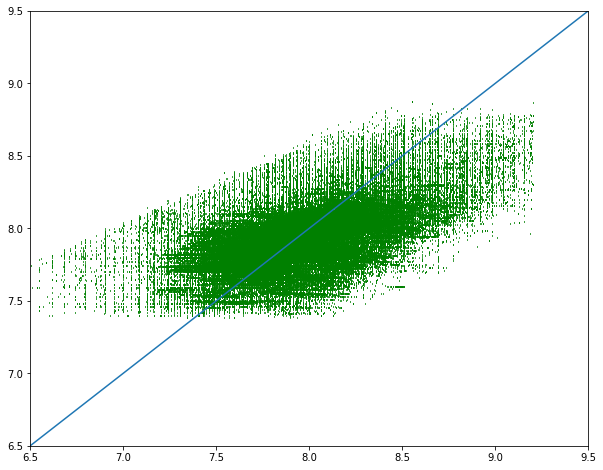

In [32]:
plt.figure(1, figsize=(10,8), )
plt.plot([6, 9.5], [6, 9.5])
plt.scatter(observed, predicted, marker=0, s=2, c='g')
plt.axis([6.5, 9.5, 6.5, 9.5])
plt.show();

In [ ]:
print(residuals.mean())
print(residuals.std())

In [ ]:
mod = sm.WLS(y, X, weights=1.)
res = mod.fit()
print(res.summary())

In [ ]:
from pymc3 import Model, NUTS, sample
from pymc3.glm import glm

with Model() as model_glm:
    glm('np.log(rent) ~ np.log(sqft) + bedrooms + bathrooms', sfbay_filtered)
    trace = sample(5000)

In [ ]:
from pymc3 import traceplot
%matplotlib inline
traceplot(trace);

In [ ]:
from scipy import optimize
from pymc3 import find_MAP
with model_glm:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(5000, start=start)

In [ ]:
traceplot(trace);

In [ ]:
import matplotlib.pyplot as plt
import theano
import pymc3 as pm

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(np.log(sfbay['sqft']), np.log(sfbay['rent']), 'o', markersize=.5, color='blue', label='sampled data')
#ax.plot(x, true_regression_line, label='true regression line', lw=2.)
#pm.glm.plot_posterior_predictive(trace, samples=100,
#                                 label='posterior predictive regression lines')
plt.legend(loc=0);

In [ ]:
#Write out selected counties for student use
sanfrancisco = geocoded[geocoded['fips_block'].str.startswith('06075')]
alameda = geocoded[geocoded['fips_block'].str.startswith('06001')]
denver = geocoded[geocoded['fips_block'].str.startswith('08031')]
washingtondc = geocoded[geocoded['fips_block'].str.startswith('11001')]
king = geocoded[geocoded['fips_block'].str.startswith('53033')]
cook = geocoded[geocoded['fips_block'].str.startswith('17031')]
neworleans = geocoded[geocoded['fips_block'].str.startswith('22071')]
suffolk = geocoded[geocoded['fips_block'].str.startswith('25025')]
manhattan = geocoded[geocoded['fips_block'].str.startswith('36061')]
kings = geocoded[geocoded['fips_block'].str.startswith('36047')]
staten = geocoded[geocoded['fips_block'].str.startswith('36085')]
bronx = geocoded[geocoded['fips_block'].str.startswith('36005')]
queens = geocoded[geocoded['fips_block'].str.startswith('36081')]
wayne = geocoded[geocoded['fips_block'].str.startswith('42127')]
multnomah = geocoded[geocoded['fips_block'].str.startswith('41051')]
austin = geocoded[geocoded['fips_block'].str.startswith('48015')]

sanfrancisco.to_csv('sanfrancisco.csv')
alameda.to_csv('alameda.csv')
denver.to_csv('denver.csv')
washingtondc.to_csv('washingtondc.csv')
king.to_csv('king.csv')
cook.to_csv('cook.csv')
neworleans.to_csv('neworleans.csv')
suffolk.to_csv('suffolk.csv')
manhattan.to_csv('manhattan.csv')
kings.to_csv('kings.csv')
staten.to_csv('staten.csv')
bronx.to_csv('bronx.csv')
queens.to_csv('queens.csv')
wayne.to_csv('wayne.csv')
multnomah.to_csv('multnomah.csv')
austin.to_csv('austin.csv')

In [ ]:
austin = geocoded[geocoded['fips_block'].str.startswith('48453')]
austin.describe()
austin.to_csv('austin.csv')

In [ ]:
middlesex = geocoded[geocoded['fips_block'].str.startswith('25017')]
middlesex.describe()
#middlesex.to_csv('middlesex.csv')

In [18]:
ca = df[df['state']=='CA']
ca

pid       date        region  \
1         5873877617 2016-11-13        merced   
15        5873876292 2016-11-13         chico   
20        5873889346 2016-11-13           slo   
25        5873893871 2016-11-13    santamaria   
50        5849643168 2016-11-13       redding   
89        5870765267 2016-11-13       hanford   
101       5873841363 2016-11-13   bakersfield   
102       5873864979 2016-11-13   bakersfield   
121       5861741895 2016-11-13       visalia   
122       5869301129 2016-11-13       visalia   
161       5873905499 2016-11-13      stockton   
162       5873901558 2016-11-13      stockton   
163       5873877740 2016-11-13      stockton   
172       5873893591 2016-11-13  santabarbara   
173       5873878077 2016-11-13  santabarbara   
174       5868278628 2016-11-13  santabarbara   
227       5873822690 2016-11-13        fresno   
228       5873852861 2016-11-13        fresno   
229       5846093616 2016-11-13        fresno   
357       5846273634 2016-11-13       ventura   
358       5873893523 2016-11-13       ventura   
359       5873891154 2016-11-13       ventura   
360       5873890101 2016-11-13       ventura   
361       5873892276 2016-11-13       ventura   
362       5873891619 2016-11-13       ventura   
363       5873890887 2016-11-13       ventura   
364       5873878261 2016-11-13       ventura   
419       5873903514 2016-11-13    sacramento   
471       5873872170 2016-11-13    sacramento   
472       5873898492 2016-11-13    sacramento   
...              ...        ...           ...   
15434237  6502958843 2018-02-19           NaN   
15434238  6502958304 2018-02-19           NaN   
15434239  6502957942 2018-02-19           NaN   
15434240  6493621673 2018-02-19           NaN   
15434241  6502955413 2018-02-19           NaN   
15434242  6502954699 2018-02-19           NaN   
15434243  6502954676 2018-02-19           NaN   
15434244  6502954514 2018-02-19           NaN   
15434245  6502950980 2018-02-19           NaN   
15434246  6502947410 2018-02-19           NaN   
15434247  6502946022 2018-02-19           NaN   
15434248  6502945796 2018-02-19           NaN   
15434249  6502944507 2018-02-19           NaN   
15434250  6502943660 2018-02-19           NaN   
15434251  6502943387 2018-02-19           NaN   
15434252  6502942072 2018-02-19           NaN   
15434253  6502940504 2018-02-19           NaN   
15434254  6502939814 2018-02-19           NaN   
15434255  6502932591 2018-02-19           NaN   
15434256  6502938725 2018-02-19           NaN   
15434314  6496711052 2018-02-19           NaN   
15434315  6495418532 2018-02-19           NaN   
15434316  6497655688 2018-02-19           NaN   
15434317  6497651409 2018-02-19           NaN   
15434318  6496641409 2018-02-19           NaN   
15434319  6489261964 2018-02-19           NaN   
15434320  6488302304 2018-02-19           NaN   
15434321  6495454862 2018-02-19           NaN   
15434322  6495452651 2018-02-19           NaN   
15434323  6502948513 2018-02-19           NaN   

                                         neighborhood    rent  bedrooms  \
1                                              Merced   925.0       2.0   
15                                              Chico   735.0       0.0   
20                                         Atascadero  1675.0       3.0   
25                                        Santa Maria  1818.0       2.0   
50                                         Wilson Ave  1050.0       2.0   
89                   500 Northstar, Hanford, CA 93230   919.0       2.0   
101                                         Tehachapi   500.0       1.0   
102                                         Tehachapi  1000.0       3.0   
121                                           Visalia  1495.0       2.0   
122                                            Tulare  1045.0       3.0   
161                                W Benjamin Holt Dr  1200.0       2.0   
162                              3700W. Benjamin Holt  1200.0       2.0   
163

In [21]:
sf = ca[ca['county']=='San Francisco']
sf.to_csv('sf.csv')